# Topological Intrusion‑Detection - Another Classical Approach
**Benign vs Botnet – Vietoris‑Rips + Persistent Homology**

Based on:  
* Westenholz et al., *Simplicial Complexes in Network Intrusion Profiling* (2024)   
* Lloyd et al., *Quantum Algorithms for Topological Data Analysis* (2015) – classical part only here 

### 0. Imports & helpers

In [5]:
import dask.dataframe as dd          # large‑CSV engine
import pandas as pd
import numpy as np
import networkx as nx
from gudhi import SimplexTree
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt
import seaborn as sns

# -------- parameters ----------
CSV_PATH   = "mergedBFXSS.csv"   # or bot.csv later
TIME_COL   = "timestamp"
SRC, DST   = "src_ip", "dst_ip"
LABEL = "label"
WEIGHT_COL = "total_payload_bytes"            # can change
WIN        = "5min"                           # resample size
VR_EPS     = 2000                             # distance/weight threshold
MAX_DIM    = 2                                # up to β2
N_JOBS     = 4                                # parallel PH cores
# --------------------------------

### 1. Load only what we need (timestamp + IPs + weight)

In [28]:
cols = [TIME_COL, SRC, DST, WEIGHT_COL, LABEL,"packets_count", "duration","bytes_rate","syn_flag_counts"]

# Read CSV with specified columns, using object dtype for payload size
ddf = dd.read_csv(
    CSV_PATH,
    usecols=cols,
    assume_missing=True,
    dtype={WEIGHT_COL: 'object'}
)

# Manually parse datetime
ddf[TIME_COL] = dd.to_datetime(ddf[TIME_COL], errors='coerce')

# Set timestamp as index with sorting to ensure global ordering
ddf = ddf.set_index(TIME_COL, sorted=False)

# Save as sorted CSV
ddf.to_csv("BFXSS_sorted.csv", index=True, single_file=True)

['/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/BFXSS_sorted.csv']

In [19]:
import pandas as pd

# Define the time window
start_time = pd.Timestamp('2018-02-23 12:00:00')
end_time = pd.Timestamp('2018-02-23 13:00:00')

# Filter dataset
subset_ddf = ddf.loc[start_time:end_time]

# Check labels
label_counts = subset_ddf['label'].value_counts().compute()
print(label_counts)


AttributeError: 'function' object has no attribute 'loc'

In [4]:
import pandas as pd
data = pd.read_csv(CSV_PATH, parse_dates=['timestamp'])

: 

: 

: 

AttributeError: 'function' object has no attribute 'reset_index'

In [21]:
print(ddf.columns)

Index(['src_ip', 'dst_ip', 'total_payload_bytes', 'label'], dtype='object')


In [ ]:
data = data[["timestamp", "src_ip", "dst_ip", "total_payload_bytes"]]
data.to_csv("BFXSS_merged_sorted.csv", index=False)

### 2. Group into 5‑minute windows

In [22]:
def agg_window(df):
    """
    Build a weighted undirected graph G for one window
    and return: Betti vector, centrality df row.
    """
    # 2.1 Graph
    if df.empty:
        return pd.DataFrame([{
            "beta_0": 0, "beta_1": 0, "beta_2": 0,
            "deg_mean": 0.0, "deg_max": 0,
            "triangles_mean": 0.0,
            "num_edges": 0
        }])
    
    G = nx.Graph()
    for _, row in df.iterrows():
        try:
            w = float(row[WEIGHT_COL])
        except Exception:
            continue
        if pd.isna(w) or w <= 0:
            continue
        if w > VR_EPS:
            w = VR_EPS
        G.add_edge(row[SRC], row[DST], weight=w)

    if len(G) < 2:
        return pd.DataFrame([{
            "beta_0": 0, "beta_1": 0, "beta_2": 0,
            "deg_mean": 0.0, "deg_max": 0,
            "triangles_mean": 0.0,
            "num_edges": 0
        }])

    # 2.2 Vietoris–Rips complex (clique complex of the ε-graph)
    st = SimplexTree()
    ip_to_int = {ip: idx for idx, ip in enumerate(G.nodes)}
    for node in G.nodes:
        st.insert([ip_to_int[node]], filtration=0.0)
    for u, v, d in G.edges(data=True):
        if d["weight"] <= VR_EPS:
            st.insert([ip_to_int[u], ip_to_int[v]], filtration=d["weight"])
    
    st.expansion(MAX_DIM)
    st.compute_persistence()

    # 2.3 Betti numbers
    betti = st.betti_numbers()
    while len(betti) <= MAX_DIM:
        betti.append(0)

    # 2.4 Simple graph centrality features
    deg_01 = dict(G.degree())
    triads = nx.triangles(G)
    num_edges = G.number_of_edges()
    df_feat = pd.DataFrame([{
        "beta_0": betti[0],
        "beta_1": betti[1],
        "beta_2": betti[2],
        "deg_mean": np.mean(list(deg_01.values())),
        "deg_max": np.max(list(deg_01.values())),
        "triangles_mean": np.mean(list(triads.values())),
        "num_edges": num_edges
    }])
    return df_feat

ddf = ddf.reset_index()

# Step 1: Floor timestamps to the start of the time window
ddf["window_start"] = ddf["timestamp"].dt.floor(WIN)  # WIN is e.g. "5min"

# Step 3: Apply the function grouped by the window_start column
features = (
    ddf.groupby("window_start")
       .apply(agg_window)
       .compute()
       .dropna()
       .reset_index()
)

features.head()



/tmp/ipykernel_6180/988796550.py:75: UserWarning: `meta` is not specified, inferred from partial data.
Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result

  .apply(agg_window)


,window_start,level_1,beta_0,beta_1,beta_2,deg_mean,deg_max,triangles_mean,num_edges
0,2018-02-22 05:30:00,0,1,0,0,1.000000,1,0.0,1
1,2018-02-23 10:45:00,0,2,0,0,6.478043,355,0.0,10326
2,2018-02-23 13:40:00,0,4,0,0,7.841223,379,0.0,10519
3,2018-02-23 16:55:00,0,1,0,0,2.265060,36,0.0,94
4,2018-02-21 19:35:00,0,0,0,0,0.000000,0,0.0,0


new visualization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 0. parameters
# -----------------------------------------------------------
metrics        = ['beta_0', 'beta_1', 'beta_2', 'deg_max', 'num_edges']
smooth_window  = 5          # rolling‑mean span (in windows)
detect_window  = 10         # window used for local μ, σ
k_sigma        = 2.5        # how many σ above μ = anomaly
# -----------------------------------------------------------


# -----------------------------------------------------------
# 1. clean up table  (features already built by agg_window)
# -----------------------------------------------------------
features = (
    features.rename(columns={'timestamp': 'time'})        
            .set_index('time', drop=True)
            .sort_index()
            [metrics]                                        # keep only the 5 metrics
)

# -----------------------------------------------------------
# 2. smooth + normalize each series to 0‑1
# -----------------------------------------------------------
smoothed = features.rolling(smooth_window, min_periods=1).mean()
normed   = (smoothed - smoothed.min()) / (smoothed.max() - smoothed.min() + 1e-9)

# -----------------------------------------------------------
# 3. compute local mean + σ and flag anomalies
# -----------------------------------------------------------
flags = pd.DataFrame(index=normed.index)

for col in metrics:
    μ  = normed[col].rolling(detect_window, min_periods=1).mean()
    σ  = normed[col].rolling(detect_window, min_periods=1).std().fillna(0)
    flags[col] = normed[col] > μ + k_sigma * σ      # True where anomaly

# a row is anomalous if *any* metric is anomalous
flags['anomaly'] = flags.any(axis=1)

# -----------------------------------------------------------
# 4. plot 
# -----------------------------------------------------------
plt.figure(figsize=(15, 6))
normed.plot(ax=plt.gca(), linewidth=1.8)                 # single call -> one line / metric

# overlay anomalies (red •)
anoms = normed[flags['anomaly']]
plt.scatter(anoms.index, anoms.max(axis=1),               # put dot at highest metric value
            color='red', s=40, zorder=5, label='anomaly')

plt.title('Normalised Betti Numbers & Graph Metrics with Detected Anomalies')
plt.xlabel('Window start')
plt.ylabel('Normalised value (0–1)')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# show anomaly windows
print("Anomaly windows detected:", anoms.index.strftime('%Y‑%m‑%d %H:%M').tolist())



KeyError: "None of ['time'] are in the columns"

In [55]:
baseline_end  = '2023-02-23 10:00'          # adjust to your year
baseline      = normed.loc[:baseline_end]

μ0 = baseline.mean()
σ0 = baseline.std()

k  = 2.5                                     # keep or tune
flags_fixed = (normed > μ0 + k*σ0)

features['baseline_anomaly'] = flags_fixed.any(axis=1)


In [56]:
pct_change = features[metrics].pct_change().abs()
features['jump_anomaly'] = (pct_change > 0.5).any(axis=1)   # 50 % jump


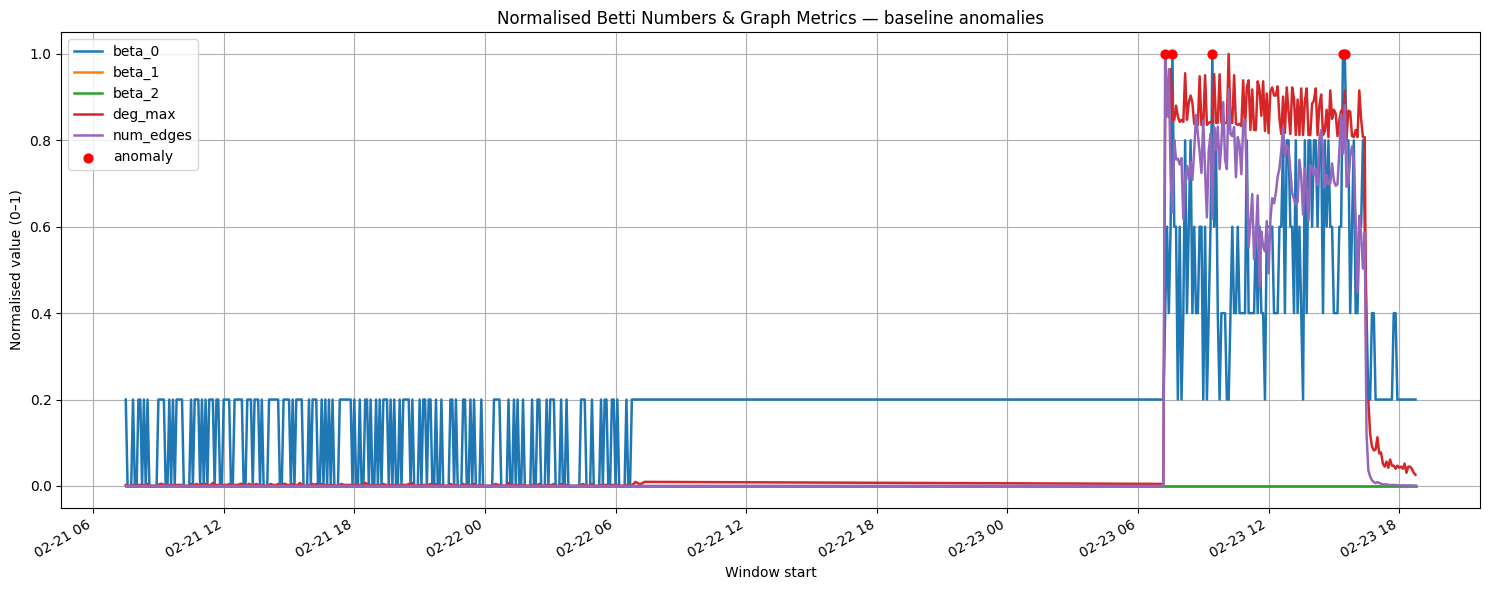

Anomaly windows: ['2018‑02‑23\xa007:15', '2018‑02‑23\xa007:35', '2018‑02‑23\xa009:25', '2018‑02‑23\xa015:25', '2018‑02‑23\xa015:30']


In [57]:
plot_cols = ['beta_0', 'beta_1', 'beta_2', 'deg_max', 'num_edges']
normed    = (features[plot_cols] - features[plot_cols].min()) \
            / (features[plot_cols].max() - features[plot_cols].min() + 1e-9)

# fixed‑baseline flags
flags_fixed = (normed > μ0 + k*σ0).any(axis=1)

plt.figure(figsize=(15,6))
normed.plot(ax=plt.gca(), linewidth=1.8)
plt.scatter(normed.index[flags_fixed],       # red dots only where baseline rule fires
            normed[flags_fixed].max(axis=1),
            color='red', s=40, label='anomaly', zorder=5)

plt.title("Normalised Betti Numbers & Graph Metrics — baseline anomalies")
plt.xlabel("Window start")
plt.ylabel("Normalised value (0–1)")
plt.grid(True);  plt.legend(loc='upper left');  plt.tight_layout();  plt.show()

print("Anomaly windows:", normed.index[flags_fixed].strftime('%Y‑%m‑%d %H:%M').tolist())


In [27]:
# Step 1: Floor timestamps to the start of the time window
ddf["window_start"] = ddf["timestamp"].dt.floor(WIN)  # WIN is e.g. "5min"

# Step 3: Apply the function grouped by the window_start column
features = (
    ddf.groupby("window_start")
       .apply(agg_window)
       .compute()
       .dropna()
       .reset_index()
)


/tmp/ipykernel_1419/266974101.py:7: UserWarning: `meta` is not specified, inferred from partial data.
Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result

  .apply(agg_window)


In [47]:

features = features.reset_index()



In [28]:
print(ddf.columns)

Index(['timestamp', 'src_ip', 'dst_ip', 'total_payload_bytes', 'window_start'], dtype='object')


In [48]:
print(features.columns)


Index(['time', 'beta_0', 'beta_1', 'beta_2', 'deg_max', 'num_edges'], dtype='object')


In [45]:
# 1. Convert window_start to datetime index
features['window_start'] = pd.to_datetime(features['window_start'])
features = features.set_index('window_start')

# 2. Anomaly detection parameters
window_size = 10
threshold_factor = 1.5  # adjust this if too sensitive or too conservative

# 3. Calculate rolling stats and anomaly flags
metrics_to_plot = ['beta_0', 'beta_1', 'beta_2', 'deg_mean', 'deg_max', 'triangles_mean']

for col in metrics_to_plot:
    features[f'{col}_mean'] = features[col].rolling(window=window_size, min_periods=1).mean()
    features[f'{col}_std'] = features[col].rolling(window=window_size, min_periods=1).std()
    features[f'{col}_anomaly'] = features[col] > (features[f'{col}_mean'] + threshold_factor * features[f'{col}_std'])

# 4. Combine all anomaly flags
features['BF_XXS_attack'] = features[[f'{col}_anomaly' for col in metrics_to_plot]].any(axis=1)

KeyError: 'window_start'

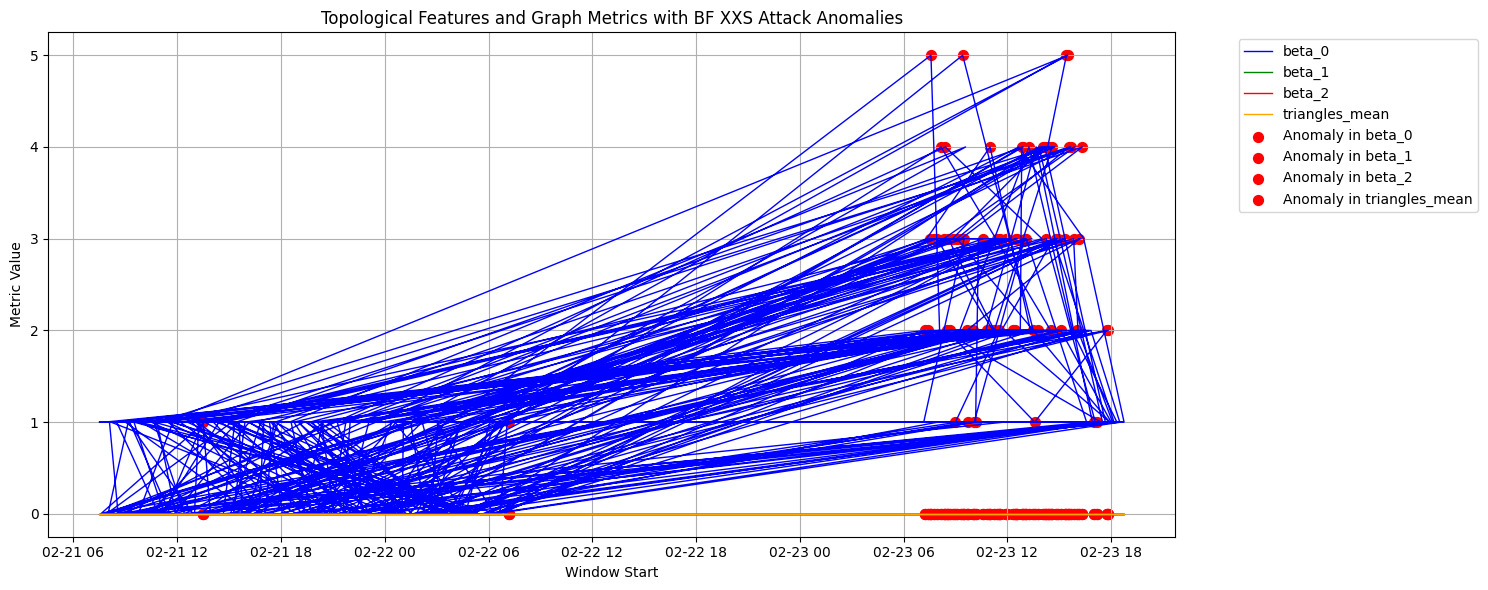

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
metrics_to_plot = ['beta_0', 'beta_1', 'beta_2', 'triangles_mean']

colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan']

# Plot each metric on the same graph
for col, color in zip(metrics_to_plot, colors):
    plt.plot(features.index, features[col], label=col, color=color, linewidth=1)

# Plot anomaly points (overlay all)
anomalies = features[features['BF_XXS_attack']]
for col, color in zip(metrics_to_plot, colors):
    plt.scatter(anomalies.index, anomalies[col], color='red', s=50, label=f'Anomaly in {col}')

plt.xlabel('Window Start')
plt.ylabel('Metric Value')
plt.title('Topological Features and Graph Metrics with BF XXS Attack Anomalies')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()


Normalized data visualization

<Figure size 1500x600 with 0 Axes>

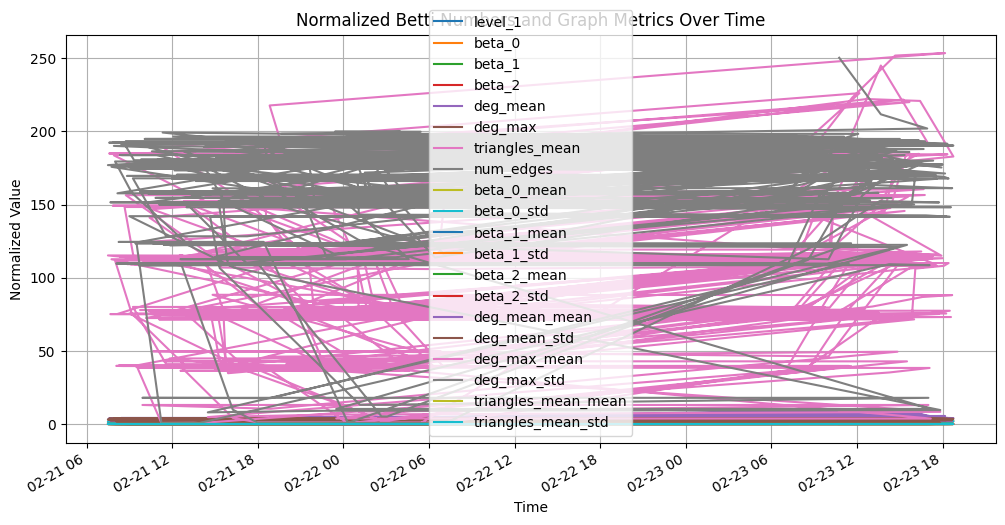

In [40]:
# Normalize for visualization only
features = features.set_index('window_start')
df_plot = features.copy()
plt.figure(figsize=(15, 6))
for col in ['beta_0', 'beta_1', 'beta_2', 'deg_max', 'num_edges']:
    df_plot[col] = (df_plot[col] - df_plot[col].min()) / (df_plot[col].max() - df_plot[col].min())

df_plot.plot(figsize=(12, 6), title="Normalized Betti Numbers and Graph Metrics Over Time")
plt.ylabel("Normalized Value")
plt.xlabel("Time")
plt.grid(True)
plt.show()

### 3. Visualise Betti spikes

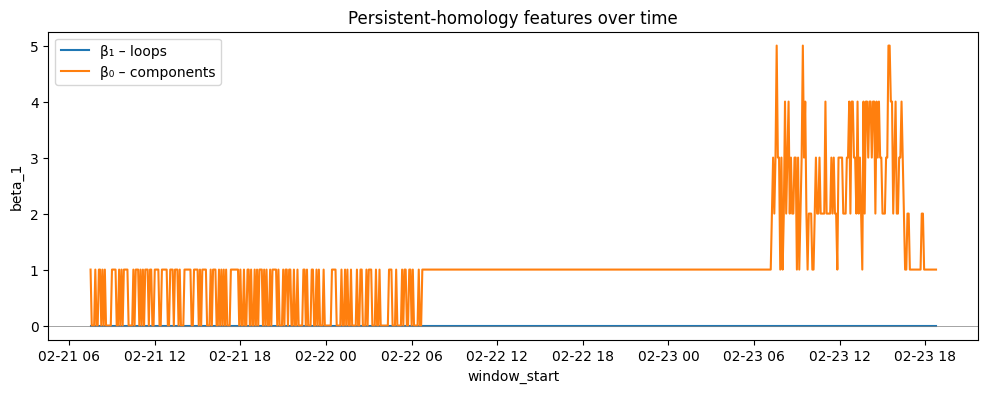

In [9]:
plt.figure(figsize=(12,4))
sns.lineplot(data=features, x="window_start", y="beta_1", label="β₁ – loops")
sns.lineplot(data=features, x="window_start", y="beta_0", label="β₀ – components")
plt.axhline(0, color="grey", lw=0.5)
plt.title("Persistent‑homology features over time")
# plt.plot(features["window_start"], features["deg_mean"], label="avg degree")
# plt.plot(features["window_start"], features["deg_max"], label="max degree")
plt.legend()

plt.show()

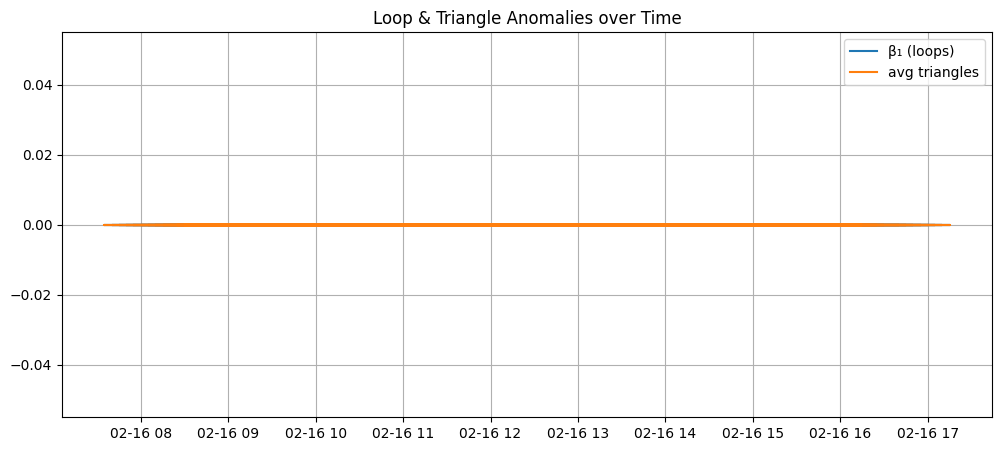

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(features["window_start"], features["beta_1"], label="β₁ (loops)")
plt.plot(features["window_start"], features["triangles_mean"], label="avg triangles")
plt.legend(); plt.grid(); plt.title("Loop & Triangle Anomalies over Time")
plt.show()

In [15]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination=0.05).fit(features[["deg_mean", "deg_max", "beta_0"]])
features["anomaly"] = clf.predict(features[["deg_mean", "deg_max", "beta_0"]])  # -1 = anomaly

### 4. Compare benign vs bot datasets

In [10]:
def load_and_extract(path, label):
    ddf = dd.read_csv(path, usecols=cols, assume_missing=True)
    ddf[TIME_COL] = dd.to_datetime(ddf[TIME_COL], errors="coerce")
    feats = (ddf
             .set_index(TIME_COL)
             .map_partitions(lambda part:
                  part.groupby(pd.Grouper(freq=WIN))
                      .apply(agg_window)
             )
             .compute()
             .dropna()
             .reset_index(names="window_start")
            )
    feats["label"] = label
    return feats

combo = load_and_extract("mergedbot.csv", "Combo")

sns.displot(combo, x="beta_1", hue="label", kind="kde", fill=True)
plt.title("β₁ distribution – Benign vs Botnet")
plt.show()


IndexError: list index out of range

### 5. Optional: persistent diagrams for a *single* window

In [ ]:
sample_window = ddf.loc["2018-03-02 09:15":"2018-03-02 09:20"].compute()
G = nx.from_pandas_edgelist(sample_window, SRC, DST,
                            edge_attr=WEIGHT_COL)
# distance matrix for ripser – simplest: 1 if edge present else 2
nodes = list(G.nodes)
n2idx = {n:i for i,n in enumerate(nodes)}
D = 2 * np.ones((len(nodes), len(nodes)))
for u,v in G.edges():
    i,j = n2idx[u], n2idx[v]
    D[i,j] = D[j,i] = 1
diagrams = ripser(D, maxdim=MAX_DIM, distance_matrix=True)['dgms']
plot_diagrams(diagrams, show=True, title="VR(ε=1) persistent diagram")


### 6. Save features for downstream ML

In [ ]:
features.to_csv("vrph_features_benign.csv", index=False)
bot_features = combo[combo.label=="Bot"]
bot_features.to_csv("vrph_features_bot.csv", index=False)